##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer model for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate Portuguese to English. This is an advanced example that assumes knowledge of [text generation](text_generation.ipynb) and [attention](nmt_with_attention.ipynb).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](text_classification_rnn.ipynb) or [CNNs](../images/intro_to_cnns.ipynb). This general architecture has a number of advantages:

* It make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [ ]:
!pip install tf-nightly
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 521.9MB 38kB/s 
     |████████████████████████████████| 3.0MB 39.7MB/s 
     |████████████████████████████████| 460kB 36.9MB/s 


In [ ]:
from sklearn.model_selection import train_test_split
import string

## Setup input pipeline

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def getdata(link):
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('Filename.txt')  
  df = open('Filename.txt', 'rb').read().decode(encoding='utf-8')
  df = df.split('\n')
  df2 = []
  for line in df:
    if line != '':
      g = line.split("\t")
      df2.append(g[0])
      df2.append(g[1])
  return df2

In [ ]:
df_bangla_trn = getdata('https://drive.google.com/open?id=1sTCskB7TMC5V6tnygw9GhYCvF7tggnqO')

In [ ]:
df_bangla_dev = getdata('https://drive.google.com/open?id=1r6oDvbBD16mcbpolSJi5uZ6bsxdz-moT')

In [ ]:
df_hindi_trn = getdata('https://drive.google.com/open?id=1VGrFZznZR4wtfiKDMLINuVKNPkuFBg8k')

In [ ]:
df_hindi_dev = getdata('https://drive.google.com/open?id=1-i5kHiZNkI75E_DaRuduIZ6PBYi9bgL_')

 **Cleaning the data** (removing extra spaces, punctuations)

In [ ]:
import string

In [ ]:
extra_str = '0123456789'
chars = set(extra_str)

In [ ]:
def cleandata(data):
  g = []
  sz = 0
  for s in data:
    q = s.translate(str.maketrans('', '', string.punctuation))
    q = q.translate(str.maketrans('','',extra_str))
    q = q.translate(str.maketrans('', '', '\u200d'))
    g.append(q)
    if len(q) != s:
      sz= sz+1
  print(sz)
  return g

In [ ]:
df_hindi_trn = cleandata(df_hindi_trn)
df_hindi_dev = cleandata(df_hindi_dev)
df_bangla_trn = cleandata(df_bangla_trn)
df_bangla_dev = cleandata(df_bangla_dev)

25874
2000
27246
2000


In [ ]:
dataf = []
special_words =[]
dataf.append(df_hindi_trn)
dataf.append(df_bangla_trn)
special_words.append('$')
special_words.append('%')

In [ ]:
dataf_test = []
dataf_test.append(df_hindi_dev)
dataf_test.append(df_bangla_dev)

In [ ]:
def preprocessWord(list,start):
  modifList = []
  for w in list:
    w = start+w.lower()+"@"
    modifList.append(w)
  return modifList

input_texts = []
target_texts = []
input_texts_test = []
target_texts_test = []

for d1,d2,s in zip(dataf,dataf_test,special_words):
  input_texts.append(preprocessWord(d1[0::2],s))
  target_texts.append(preprocessWord(d1[1::2],s))
  input_texts_test.append(preprocessWord(d2[0::2],s))
  target_texts_test.append(preprocessWord(d2[1::2],s))

In [ ]:
lang_size_tst = []
for x in input_texts_test:
  lang_size_tst.append(len(x))


In [ ]:
def mergeinput(input_texts,target_texts):
  input_temp = []
  target_temp = []
  lang_size_trn = []

  for input_text,target_text in zip(input_texts,target_texts):
    sz = 0
    for i in range(len(input_text)):
      no_of_spaces = 0
      for w in input_text[i]:
        if(w == ' '):
          no_of_spaces += 1
      for w in target_text[i]:
        if(w == ' '):
          no_of_spaces -= 1
      if(no_of_spaces != 0 ):
        print(input_text[i] +" -> "+target_text[i])
      elif(len(input_text[i]) <= 25 and len(target_text[i]) <= 30):
          input_temp.append(input_text[i])
          target_temp.append(target_text[i])
          sz += 1
    lang_size_trn.append(sz)

  iptxt = input_texts
  trgtxt = target_texts
  input_text = input_temp
  target_text = target_temp
  return input_text,target_text,lang_size_trn

In [ ]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
# no. of languages  = 2 (hindi, bangla)
shuffle_in_unison(input_texts[0], target_texts[0])
shuffle_in_unison(input_texts[1], target_texts[1])
input_text,target_text,lang_size_trn = mergeinput(input_texts,target_texts)

$vaparaiso church of christ@ -> $व्हापरासिओ@
$changez khan@ -> $चंगेज़ खानचंगेज़ खान@
$envoy communications group@ -> $एन्वॉय कम्युनिकेशंस@
$south arlington church of christ@ -> $साउथ अर्लिंग्टन@
$order of vasa@ -> $ऑडर ऑफ़ द वासा@
$retalix@ -> $रेटालिक्स लि@
$srisailam@ -> $श्री शैलम@
$rama lingeshwara@ -> $रामालिंगेश्वर@
$sea of the hebrides@ -> $सी ऑफ हरब्रिड्स@
$wind river@ -> $विंडरिवर@
$paris charles de gaulle@ -> $पेरिस रॉसे चार्ल्स डे ग्यूले@
$theodore roosevelt@ -> $थियोडोर रूजवेल्टथीओडोर रूज़वेल्ट@
$walter scott@ -> $वॉल्टरस्कॉट@
$rediffcom india limited@ -> $रेडिफ़ डॉट कॉम इंडिया लिमिटेड@
$ramcoind@ -> $राम्को इंड@
$gothenburg landvetter@ -> $गॉथेनबर्गलेंडवेटर@
$ronald reagan@ -> $रॉनाल्ड रेगनरोनाल्ड रीगन@
$king edward vii@ -> $किंग एडवर्ड@
$ray illingworth@ -> $रे इलिंगवर्थरे इलिंगवॉर्थ@
$saint john the baptist high schoolthane@ -> $सेंट जॉन द बैप्टिस्ट हाई स्कूल ठाणे@
$state bnk tr@ -> $स्टेट बैंक ऑफ त्रावणकोर@
$westminster presbyterian@ -> $वेस्टमिनस्टर प्रेसबिटेरियनवेस्टमि

In [ ]:
input_text_tst,target_text_tst,lang_size_tst = mergeinput(input_texts_test,target_texts_test)

$hewlett  packard@ -> $ह्यूलेटपैकर्ड@
$stats chippac@ -> $स्टेट्सचिपपैक@
$stoltnielsen@ -> $स्टॉल्ट निलसन@


In [ ]:
# Combining train and test data
input_trn_tst = input_text + input_text_tst
target_trn_tst = target_text + target_text_tst

In [ ]:
input_vocab = sorted(set("".join(input_trn_tst)))
target_vocab = sorted(set("".join(target_trn_tst)))

In [ ]:
assert len(input_trn_tst) == len(target_trn_tst)

In [ ]:
train_sz = 0;
for x in (lang_size_trn):
  train_sz+=x
test_sz = 0
for x in lang_size_tst:
  test_sz+=x
assert train_sz == len(input_text)
assert train_sz == len(target_text)



In [ ]:
# Creating a mapping from unique characters to indices in input text English
char2idxEn = {}
idx2charEn = {}
char2idxEn["<"] = 0
for index, word in enumerate(input_vocab):
      char2idxEn[word] = index + 1
# print(char2idxEn)
for word, index in char2idxEn.items():
      idx2charEn[index] = word


# Creating a mapping from unique characters to indices in input text Hindi
char2idxHi = {}
idx2charHi = {}
char2idxHi["<"] = 0
for index, word in enumerate(target_vocab):
      char2idxHi[word] = index + 1
for word, index in char2idxHi.items():
      idx2charHi[index] = word



In [ ]:
def getIpTextasInt(c):
  f = np.array([ char2idxEn[i] for i in c])
  return f

def getTargTextasInt(c):
  f = np.array([ char2idxHi[i] for i in c])
  return f

In [ ]:
input_text_as_int = np.array([getIpTextasInt(c) for c in input_trn_tst])
input_char_dataset = [tf.data.Dataset.from_tensor_slices(i) for i in input_text_as_int]

In [ ]:
target_text_as_int = np.array([getTargTextasInt(c) for c in target_trn_tst])
target_char_dataset = [tf.data.Dataset.from_tensor_slices(i) for i in target_text_as_int]

In [ ]:
examples_per_epoch = len(input_text)
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE
BUFFER_SIZE = 10000
steps_per_epoch

408

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
input_tensor = [];
target_tensor = [];
for i in range(0, len(input_text_as_int)):
  input_tensor.append(tf.convert_to_tensor(input_text_as_int[i]))
  target_tensor.append(tf.convert_to_tensor(target_text_as_int[i]))
maxlen_inp = max(max_length(input_tensor), max_length(target_tensor));
maxlen_targ = max(max_length(input_tensor), max_length(target_tensor));
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, padding='post', maxlen = maxlen_inp)
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post', maxlen = maxlen_targ)

In [ ]:
maxlen_inp

30

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=test_sz,shuffle=False)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(26150, 26150, 1976, 1976)

In [ ]:
from sklearn.utils import shuffle

In [ ]:
BUFFER_SIZE = len(input_tensor)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 512
d_model = 128
num_heads = 8
input_vocab_size = len(input_vocab)+2
target_vocab_size = len(target_vocab)+2
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).shuffle(buffer_size= BUFFER_SIZE)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


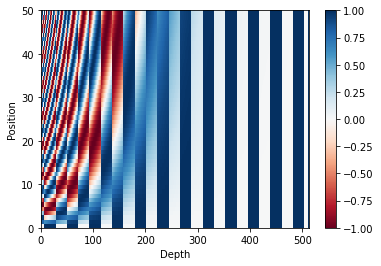

In [ ]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)
  

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    # why this extra line, coz this was not mentioned in model
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((64, 62, 128))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([64, 62, 512]), TensorShape([64, 8, 62, 62]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(500, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 500])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [ ]:
input_vocab_size

36

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    return x  # (batch_size, input_seq_len, d_model)

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
     
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    
    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder1 = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)
    self.decoder2 = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask, num_heads, maxlen_targ, batch_size):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output = tf.random.uniform((batch_size, maxlen_targ, d_model))
    if(inp[0][0] == char2idxEn["$"]):
      dec_output, attention_weights = self.decoder1(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    if(inp[0][0] == char2idxEn["%"]):
      dec_output, attention_weights = self.decoder2(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=100, 
                          pe_target=100,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
maxlen_inp

30

In [ ]:
num_heads

8

In [ ]:
EPOCHS = 50

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(64, maxlen_inp), dtype=tf.int32),
    tf.TensorSpec(shape=(64, maxlen_targ), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions= transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask, num_heads, maxlen_targ, BATCH_SIZE)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)



```
# This is formatted as code
```

English is used as the input language and Hindi is the target language.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.2635 Accuracy 0.0221
Epoch 1 Batch 50 Loss 5.0477 Accuracy 0.0085
Epoch 1 Batch 100 Loss 4.6132 Accuracy 0.0193
Epoch 1 Batch 150 Loss 4.3493 Accuracy 0.0242
Epoch 1 Batch 200 Loss 4.1672 Accuracy 0.0282
Epoch 1 Batch 250 Loss 4.0246 Accuracy 0.0328
Epoch 1 Batch 300 Loss 3.8971 Accuracy 0.0372
Epoch 1 Batch 350 Loss 3.7833 Accuracy 0.0414
Epoch 1 Batch 400 Loss 3.6792 Accuracy 0.0453
Epoch 1 Loss 3.6651 Accuracy 0.0459
Time taken for 1 epoch: 59.31021189689636 secs

Epoch 2 Batch 0 Loss 2.7336 Accuracy 0.0835
Epoch 2 Batch 50 Loss 2.6818 Accuracy 0.0877
Epoch 2 Batch 100 Loss 2.6217 Accuracy 0.0889
Epoch 2 Batch 150 Loss 2.5636 Accuracy 0.0913
Epoch 2 Batch 200 Loss 2.5221 Accuracy 0.0931
Epoch 2 Batch 250 Loss 2.4844 Accuracy 0.0950
Epoch 2 Batch 300 Loss 2.4453 Accuracy 0.0972
Epoch 2 Batch 350 Loss 2.4020 Accuracy 0.0997
Epoch 2 Batch 400 Loss 2.3552 Accuracy 0.1024
Epoch 2 Loss 2.3499 Accuracy 0.1028
Time taken for 1 epoch: 32.977914571762085 secs

Epoch 3 B

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [ ]:
MAX_LENGTH = 62

In [ ]:
def evaluate(word):
  inputs = [char2idxEn[i] for i in (word)]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=maxlen_inp, padding='post')
  inputs = tf.convert_to_tensor(inputs)
  # print(inputs)
  # start_token = [tokenizer_pt.vocab_size]
  # end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  # inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = inputs
  # print(encoder_input)
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [char2idxHi[word[0]]]
  output = tf.expand_dims(decoder_input, 0)
  # print("check1 passed")
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
    # print("check2 passed")
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions = transformer(encoder_input, output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask,num_heads, maxlen_targ, BATCH_SIZE)
    # print("check3 passed")
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == char2idxHi['@']:
      return tf.squeeze(output, axis=0)
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
  return tf.squeeze(output, axis=0)

In [ ]:
def translate(sentence):
  
  result = evaluate(sentence)
  predicted_sentence = ""
  # print(result)
  for i in result:
    if i >= len(special_words)+2:
      predicted_sentence += idx2charHi[i.numpy()]
  print(predicted_sentence)
 
  # print(predicted_sentence)  

  # print('Input: {}'.format(sentence))
  # print('Predicted translation: {}'.format(predicted_sentence))
  
  # if plot:
  #   plot_attention_weights(attention_weights, sentence, result, plot)

In [ ]:
idx2charHi[1]

' '

In [ ]:
translate("$priyanka@")
# print ("Real translation: this is a problem we have to solve .")

प्रियांका


In [ ]:
special_chars = special_words
special_chars.append('@')
special_chars.append('<')
special_char_set = set(special_chars)

In [ ]:
# @tf.function
def predictAccuracyBg(mismatch_pair,strmismatch):
  ip = "";
  cnt = 0;
  output = "";
  trueVal = "";
  cnt2char = 0;
  totalcharcnt = 0;
  avgmismatch = 0;
  mismatchcnt = 0;
  total_bangla_word = 0
  l = (int)(len(input_tensor_val));
  for i in range(0, l):
    print(100*i/l, "% completed")
    input_word = input_tensor_val[i];
    target_word = target_tensor_val[i];
    if(input_word[0] != char2idxEn["%"]):
      continue
    total_bangla_word += 1
    for r in input_word:
      if(r == 0):
        break
      else: 
        ip += idx2charEn[r]
    # print("hi")
    result = evaluate(ip)
    
    for k in result:
      if (idx2charHi[k.numpy()] not in special_char_set):
        output += idx2charHi[k.numpy()]
    # print(output)
    # print("hilo")
    # print(word)
    for r in target_word:
      if(idx2charHi[r] not in special_char_set):
        trueVal += idx2charHi[r]
    print(trueVal+"  : "+output);
    # print(output)
    if(len(output) == len(trueVal)):
      wordlen = len(trueVal);
      totalcharcnt += int(wordlen);
      tempcnt = 0;
      for k in range(0,int(wordlen)):
        if(output[k] == trueVal[k]):
          cnt2char +=  1;
        else :
          mismatch_pair.append({output[k], trueVal[k]});
          strmismatch += output[k];
          tempcnt += 1;
          mismatchcnt += 1;
      avgmismatch += (tempcnt/wordlen);
    if(output==trueVal):
      cnt = cnt+1; 
    ip = ""
    output = ""
    trueVal = ""
    
  print(100*cnt/(int(total_bangla_word)))
  print(100*cnt2char/totalcharcnt);
  print(avgmismatch/(l-cnt));
  print(set(strmismatch));
  return 100*cnt/(int(l)), 100*cnt2char/totalcharcnt, (avgmismatch/(l-cnt)), set(strmismatch)

In [ ]:
mismatch_pair = [];
strmismatch = "";
a,b,c,d = predictAccuracyBg(mismatch_pair,strmismatch)

0.0 % completed
0.05060728744939271 % completed
0.10121457489878542 % completed
0.15182186234817813 % completed
0.20242914979757085 % completed
0.25303643724696356 % completed
0.30364372469635625 % completed
0.354251012145749 % completed
0.4048582995951417 % completed
0.45546558704453444 % completed
0.5060728744939271 % completed
0.5566801619433198 % completed
0.6072874493927125 % completed
0.6578947368421053 % completed
0.708502024291498 % completed
0.7591093117408907 % completed
0.8097165991902834 % completed
0.8603238866396761 % completed
0.9109311740890689 % completed
0.9615384615384616 % completed
1.0121457489878543 % completed
1.062753036437247 % completed
1.1133603238866396 % completed
1.1639676113360324 % completed
1.214574898785425 % completed
1.2651821862348178 % completed
1.3157894736842106 % completed
1.3663967611336032 % completed
1.417004048582996 % completed
1.4676113360323886 % completed
1.5182186234817814 % completed
1.5688259109311742 % completed
1.6194331983805668 % 

In [ ]:
# @tf.function
def predictAccuracyHi(mismatch_pair,strmismatch):
  ip = "";
  cnt = 0;
  output = "";
  trueVal = "";
  cnt2char = 0;
  totalcharcnt = 0;
  avgmismatch = 0;
  mismatchcnt = 0;
  total_hindi_word = 0
  l = (int)(len(input_tensor_val));
  for i in range(0, l):
    print(100*i/l, "% completed")
    input_word = input_tensor_val[i];
    target_word = target_tensor_val[i];
    if(input_word[0] != char2idxEn["$"]):
      continue
    total_hindi_word += 1
    for r in input_word:
      if(r == 0):
        break
      else: 
        ip += idx2charEn[r]
    # print("hi")
    result = evaluate(ip)
    
    for k in result:
      if (idx2charHi[k.numpy()] not in special_char_set):
        output += idx2charHi[k.numpy()]
    # print(output)
    # print("hilo")
    # print(word)
    for r in target_word:
      if(idx2charHi[r] not in special_char_set):
        trueVal += idx2charHi[r]
    print(trueVal+"  : "+output);
    # print(output)
    if(len(output) == len(trueVal)):
      wordlen = len(trueVal);
      totalcharcnt += int(wordlen);
      tempcnt = 0;
      for k in range(0,int(wordlen)):
        if(output[k] == trueVal[k]):
          cnt2char +=  1;
        else :
          mismatch_pair.append({output[k], trueVal[k]});
          strmismatch += output[k];
          tempcnt += 1;
          mismatchcnt += 1;
      avgmismatch += (tempcnt/wordlen);
    if(output==trueVal):
      cnt = cnt+1; 
    ip = ""
    output = ""
    trueVal = ""
    
  print(100*cnt/(int(total_hindi_word)))
  print(100*cnt2char/totalcharcnt);
  print(avgmismatch/(l-cnt));
  print(set(strmismatch));
  return 100*cnt/(int(l)), 100*cnt2char/totalcharcnt, (avgmismatch/(l-cnt)), set(strmismatch)

In [ ]:
mismatch_pair1 = [];
strmismatch1 = "";
a1,b1,c1,d1 = predictAccuracyHi(mismatch_pair1,strmismatch1)

0.0 % completed
आचार्यनंदना  : आचार्यनंदना
0.05060728744939271 % completed
आचार्यसुत  : आचार्यसुत
0.10121457489878542 % completed
आचार्यनंदन  : आचार्यनंदन
0.15182186234817813 % completed
आचार्यनंदना  : आचार्यनंदना
0.20242914979757085 % completed
आदमखोर  : आड़मखोर
0.25303643724696356 % completed
आग और शोला  : आग और शोला
0.30364372469635625 % completed
आज की बात  : आज की बात
0.354251012145749 % completed
आज की ताज़ा खबर  : आज की ताज़ा खबार
0.4048582995951417 % completed
आकांक्षा  : आकांक्षा
0.45546558704453444 % completed
आन  : आन
0.5060728744939271 % completed
आँखों देखी  : आँखों देखी
0.5566801619433198 % completed
आँसू बन गए फ़ूल  : आँसू बान गए फूल
0.6072874493927125 % completed
आशा  : आशा
0.6578947368421053 % completed
आतंक  : आतंक
0.708502024291498 % completed
अब क्या होगा  : अब क्या होगा
0.7591093117408907 % completed
अब्दुल हाकिम  : अब्दुल हकीम
0.8097165991902834 % completed
अब्दुल हन्नान  : अब्दुल हन्नान
0.8603238866396761 % completed
अब्दुल मुहासिन  : अब्दुल मुहसीन
0.910931174089068

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.

In [ ]:
for (batch, (inp, tar)) in enumerate(dataset):
  print(inp[0][0] == char2idxHi["$"])
  break

In [ ]:
embedding = tf.keras.layers.Embedding(4, 128)